In [1]:
import decode_eeg
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
%load_ext autoreload
%autoreload 2

In [2]:
# Classification parameters and setup
time_window = 50
time_step = 25
n_splits = 1000
trial_averages = [20]
group_dict = {0:[1],1:[2],2:[3],3:[4]}
test = False # if true, test pipeline on only 3 subjects
experiment_names = ['1801','1901','1902']

Experiment: 1801

Trial Bin: 20

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
Saving output\figures\1801_trialbin20_acc20210528_0704.pdf
Saving output\figures\1801_trialbin20_acc20210528_0704.png


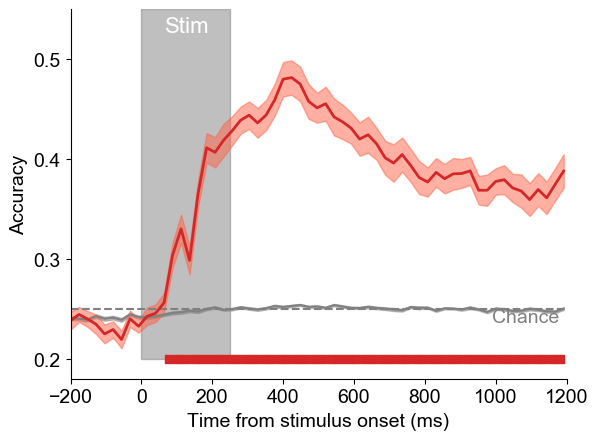

Experiment: 1901

Trial Bin: 20

0
1
2
3
4
5
6
7
8
9
10
11
12


KeyboardInterrupt: 

In [3]:
# If you want to retrain classifiers, run this cell. Otherwise go to next cell.

# loop over all 3 experiments
for experiment_name in experiment_names:
    print(f'Experiment: {experiment_name}\n')
    # loop over trial bin sizes
    for trial_average in trial_averages:
        print(f'Trial Bin: {trial_average}\n')

        # create experiment, data wrangler, and classification objects
        data_dir = f'./data/{experiment_name}'
        exp = decode_eeg.Experiment(experiment_name,data_dir,test=test)
        wrangl = decode_eeg.Wrangler(exp.info['times'],time_window,time_step,trial_average,n_splits,group_dict)
        clfr = decode_eeg.Classification(wrangl,exp.nsub)

        # loop over subjects in experiment
        for isub in range(exp.nsub):
            print(isub)

            # load and format data
            xdata,ydata = exp.load_eeg(isub)
            xdata,ydata = wrangl.setup_data(xdata,ydata)
            
            # split data into train and test
            for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_split(xdata,ydata):
                y_test_shuffle = np.random.permutation(y_test)
                # roll over trial timecourse
                for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                    # do classification
                    clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)

        # create classification interpreter object
        interp = decode_eeg.Interpreter(clfr, subtitle = f'{experiment_name}_trialbin{str(trial_average)}_')
        interp.save_results()

        # plot classification results
        interp.plot_acc(significance_testing=True,savefig=1)

## Loading previous classification results

In [4]:
# Set up interp object and load results.
interp = decode_eeg.Interpreter()
# interp.load_results()

In [ ]:
# plot classification results
interp.plot_acc(significance_testing=True,savefig=0)